<a href="https://colab.research.google.com/github/IvanKatorgin/NLP/blob/main/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B5%D1%81%D1%82%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D1%8F%D0%B7%D1%8B%D0%BA%D0%B0_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Обработка естественного языка". Домашнее задание 3. Извлечение информации. Каторгин И.П.

## Задание

Цель: получить навыки решения классических задач NLP

Задание 1: составить словари для классификации по тональности.

Данные для задания — отзывы на банки, собранные с нескольких сайтов рунета. Отзывы могут быть как положительными — оценка 5, так и отрицательными — оценка 1.
1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec
2. Приведите несколько удачных и неудачных примеров решения стандартных
текстов для word2vec:
- тест на определение ближайших слов
- тест на аналогии (мужчина — король : женщина — королева)
- тест на определение лишнего слова
3. Постройте несколько визуализаций:
- TSNE для топ-100 или топ-500 слов и найдите осмысленные кластеры слов
- задайте координаты для нового пространства следующим образом: одна ось описывает отношение «плохо — хорошо», вторая — «медленно — быстро», и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

Задание 2: распространить метку.
1. Определите 5–8 позитивных слов (например, быстрый, удобный) и 5–8 негативных слов (например, очередь, медленно). Эти слова будут основной будущего оценочного словаря
2. Пусть позитивному классу соответствует метка 1, негативному -1
3. Пометьте выбранные слова в лексическом графе соответствующими метками
4. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе
5. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 — это и есть искомые оценочные слова. Алгоритмы распространения метки устроены примерно так: пусть мы находимся в вершине, помеченной +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation```
3. ```sklearn.semi_supervised.LabelSpreading```

## Загрузим и посмотрим на данные

Загрузим необходимые библиотеки:

In [ ]:
!pip install numpy==1.23.5
!pip install gensim

In [ ]:
from gensim.models import Word2Vec

In [ ]:
import pandas as pd
import random
import nltk
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
import json
import bz2
import regex
from scipy import sparse
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()
import re
from pymystem3 import Mystem
from collections import Counter
from sklearn.manifold import TSNE

In [ ]:
!pip install igraph

In [ ]:
import igraph as ig

In [ ]:
!pip install rusenttokenize

In [ ]:
from rusenttokenize import ru_sent_tokenize

In [ ]:
# загрузим файл
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

0it [00:02, ?it/s]

Посмотрим на пример отзыва:

In [ ]:
# посмотрим на пример отзыва
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Задание 1: составить словари для классификации по тональности

Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. Обучите по коллекции предложений word2vec

In [ ]:
# Перегоняем отзывы в dataframe
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [ ]:
df.loc[1]['text']

'Доброго дня! Являюсь держателем зарплатной карты , выданной Сбербанком России. В 2008 году сменила фамилию, предоставила в банк \xa0документы (копию нового паспорта, свидетельства о браке), мне перевыпустили карту на фамилию мужа ТОКАРЕВА МАРИЯ АЛЕКСАНДРОВНА (девичья \xa0- СЕКЛЕТИНА). \xa0 Возникла необходимость подключить услугу Сбербанк онлайн, НЕ ПОЛУЧИЛОСЬ (на главной странице на отображались мои карты). Связалась с техническим специалистом отделения Сбербанка в котором обслуживалась. Он пояснил, что в базе банка, я все ещё под девичьей фамилией СЕКЛЕТИНА. Предложил выслать сканы необходимых документов. Выслала, оставив контакты, звонка так и не дождалась. Ч/з некоторое время звоню сама, объясняю ситуацию, меня пробивают по базе - опять числюсь СЕКЛЕТИНОЙ (хотя карту уже перевыпустили еще раз на фамилию ТОКАРЕВА в связи с истечением срока обслуживания). Высылаю документы (копию паспорта и свидетельства о браке). Результат \xa0- 0 (ноль). ПРошу помочь разобраться в этой ситуации. С

In [ ]:
regex = re.compile("[а-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [ ]:
words_only(df.loc[1]['text'].lower())

'доброго дня являюсь держателем зарплатной карты выданной сбербанком россии в году сменила фамилию предоставила в банк документы копию нового паспорта свидетельства о браке мне перевыпустили карту на фамилию мужа токарева мария александровна девичья секлетина возникла необходимость подключить услугу сбербанк онлайн не получилось на главной странице на отображались мои карты связалась с техническим специалистом отделения сбербанка в котором обслуживалась он пояснил что в базе банка я все ещ под девичьей фамилией секлетина предложил выслать сканы необходимых документов выслала оставив контакты звонка так и не дождалась ч з некоторое время звоню сама объясняю ситуацию меня пробивают по базе опять числюсь секлетиной хотя карту уже перевыпустили еще раз на фамилию токарева в связи с истечением срока обслуживания высылаю документы копию паспорта и свидетельства о браке результат ноль прошу помочь разобраться в этой ситуации с уважением токарева мария александровна'

In [ ]:
def sentences(text):
    try:
        return [words_only(sent.lower()) for sent in ru_sent_tokenize(text)]
    except:
        return []


In [ ]:
sentences(df.loc[1]['text'])

['доброго дня',
 'являюсь держателем зарплатной карты выданной сбербанком россии',
 'в году сменила фамилию предоставила в банк документы копию нового паспорта свидетельства о браке мне перевыпустили карту на фамилию мужа токарева мария александровна девичья секлетина',
 'возникла необходимость подключить услугу сбербанк онлайн не получилось на главной странице на отображались мои карты',
 'связалась с техническим специалистом отделения сбербанка в котором обслуживалась',
 'он пояснил что в базе банка я все ещ под девичьей фамилией секлетина',
 'предложил выслать сканы необходимых документов',
 'выслала оставив контакты звонка так и не дождалась',
 'ч з некоторое время звоню сама объясняю ситуацию меня пробивают по базе опять числюсь секлетиной хотя карту уже перевыпустили еще раз на фамилию токарева в связи с истечением срока обслуживания',
 'высылаю документы копию паспорта и свидетельства о браке',
 'результат ноль',
 'прошу помочь разобраться в этой ситуации',
 'с уважением токарев

In [ ]:
# загрузим стоп-слова
from nltk.corpus import stopwords
nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'п', '-', 'В', 'И', 'на', 'На', 'Но', 'но', 'А', 'а', 'Я', ',', '.', '.', '-', '!', '!', '"', 'г', 'в', 'и', 'не', 'я', 'ч', 'з']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_stopwords(sentences, mystopwords = mystopwords):
    try:
        out = []
        for sentence in sentences:
            out.append(" ".join([token for token in sentence.split() if not token in mystopwords]))
        return out
    except:
        return []

In [ ]:
remove_stopwords(sentences(df.loc[1]['text']))

['доброго дня',
 'являюсь держателем зарплатной карты выданной сбербанком россии',
 'году сменила фамилию предоставила банк документы копию нового паспорта свидетельства браке перевыпустили карту фамилию мужа токарева мария александровна девичья секлетина',
 'возникла необходимость подключить услугу сбербанк онлайн получилось главной странице отображались мои карты',
 'связалась техническим специалистом отделения сбербанка котором обслуживалась',
 'пояснил базе банка ещ девичьей фамилией секлетина',
 'предложил выслать сканы необходимых документов',
 'выслала оставив контакты звонка дождалась',
 'некоторое время звоню сама объясняю ситуацию пробивают базе числюсь секлетиной хотя карту перевыпустили фамилию токарева связи истечением срока обслуживания',
 'высылаю документы копию паспорта свидетельства браке',
 'результат ноль',
 'прошу помочь разобраться ситуации',
 'уважением токарева мария александровна']

In [ ]:
mystem = Mystem()
def mystem_lemmas(sentences, mystem=mystem):
    res = []
    for sentence in sentences:
        try:
            res.append([l for l in mystem.lemmatize(sentence) if l.isalpha()])
        except:
            pass
    return res

In [ ]:
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']

In [ ]:
def remove_stoplemmas(sentences):
    res = []
    for sentence in sentences:
        if len(sentence) > 0:
            res.append([lemma for lemma in sentence if not lemma in mystoplemmas])
    return res

In [ ]:
def preprocessing(text):
    sents = sentences(text)
    no_stopwords = remove_stopwords(sents)
    lemmas = mystem_lemmas(no_stopwords)
    no_stoplemmas = remove_stoplemmas(lemmas)
    flat_lemmas = [lemma for sentence in no_stoplemmas for lemma in sentence]
    return flat_lemmas

In [ ]:
%%time
preprocessing(df.loc[1]['text'])

CPU times: user 14.8 ms, sys: 1.84 ms, total: 16.6 ms
Wall time: 1.21 s


['добрый',
 'день',
 'являться',
 'держатель',
 'зарплатной',
 'карта',
 'выдавать',
 'сбербанк',
 'россия',
 'год',
 'сменить',
 'фамилия',
 'предоставлять',
 'банк',
 'документ',
 'копия',
 'новый',
 'паспорт',
 'свидетельство',
 'брак',
 'перевыпускать',
 'карта',
 'фамилия',
 'муж',
 'токарева',
 'мария',
 'александровна',
 'девичий',
 'секлетина',
 'возникать',
 'необходимость',
 'подключать',
 'услуга',
 'сбербанк',
 'онлайн',
 'получаться',
 'главный',
 'страница',
 'отображаться',
 'мой',
 'карта',
 'связываться',
 'технический',
 'специалист',
 'отделение',
 'сбербанк',
 'обслуживаться',
 'пояснять',
 'база',
 'банк',
 'ещ',
 'девичий',
 'фамилия',
 'секлетина',
 'предлагать',
 'высылать',
 'скан',
 'необходимый',
 'документ',
 'высылать',
 'оставлять',
 'контакт',
 'звонок',
 'дождаться',
 'некоторый',
 'время',
 'звонить',
 'сам',
 'объяснять',
 'ситуация',
 'пробивать',
 'база',
 'числиться',
 'секлетина',
 'хотя',
 'карта',
 'перевыпускать',
 'фамилия',
 'токарева',
 'связ

In [ ]:
df['lemmas'] = df['text'].progress_apply(preprocessing)

  0%|          | 0/153499 [00:00<?, ?it/s]

In [ ]:
df.to_pickle('df.zip')

In [ ]:
df = pd.read_pickle('df.zip')
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lemmas
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"[добрый, день, являться, клиент, банк, поручит..."
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"[добрый, день, являться, держатель, зарплатной..."
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"[здравствовать, дублировать, заявление, можайс..."
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"[добрый, день, открывать, расчетный, счет, сбе..."
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"[взять, кредит, ваш, банк, заявлять, я, сумма,..."


In [ ]:
cnt_lemmas = Counter()
n_types_lemmas = []
n_tokens_lemmas = []
tokens_lemmas = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens_lemmas = row['lemmas']
    cnt_lemmas.update(tokens_lemmas)
    n_types_lemmas.append(len(cnt_lemmas))
    n_tokens_lemmas.append(sum(list(cnt_lemmas.values())))
for i in cnt_lemmas.most_common(10):
    print(i)

  0%|          | 0/153499 [00:00<?, ?it/s]

('банк', 623339)
('карта', 334996)
('деньги', 179734)
('день', 173041)
('мой', 163042)
('кредит', 156177)
('отделение', 144050)
('клиент', 136892)
('сотрудник', 134168)
('счет', 126894)


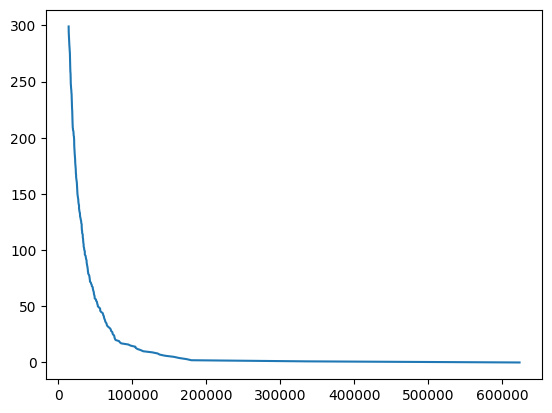

In [ ]:
freqs = list(cnt_lemmas.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

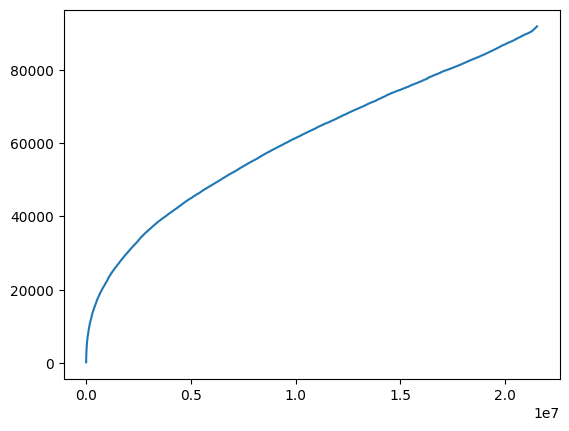

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_tokens_lemmas, n_types_lemmas)
plt.show()

Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
- тест на определение ближайших слов
- тест на аналогии (мужчина — король : женщина — королева)
- тест на определение лишнего слова

In [ ]:
w2vec = Word2Vec(sentences=df['lemmas'], min_count=20, workers=4)

In [ ]:
w2vec.save('w2vec.model')

In [ ]:
w2vec = Word2Vec.load('w2vec.model')

In [ ]:
w2vec.wv.most_similar('ипотека')

[('автокредит', 0.8326771259307861),
 ('кредит', 0.7040268182754517),
 ('потребкредит', 0.6933069825172424),
 ('ипотечный', 0.6715693473815918),
 ('новостройка', 0.6640956401824951),
 ('жилье', 0.6191520094871521),
 ('ссуда', 0.6063936352729797),
 ('вторичка', 0.6005709767341614),
 ('дельтакредит', 0.5985075831413269),
 ('недвижимость', 0.588889479637146)]

In [ ]:
w2vec.wv.doesnt_match('автокредит кредит недвижимость'.split())

'недвижимость'

In [ ]:
w2vec.wv.doesnt_match('автокредит кредит ипотека'.split())

'кредит'

In [ ]:
w2vec.wv.doesnt_match('ипотека жилье недвижимость'.split())

'ипотека'

In [ ]:
w2vec.wv.doesnt_match('вклад кредит депозит'.split())

'кредит'

In [ ]:
w2vec.wv.most_similar('клиент')

[('вкладчик', 0.6503581404685974),
 ('уважительный', 0.5278537273406982),
 ('клиентка', 0.5079188942909241),
 ('заемщик', 0.4965582489967346),
 ('пользователь', 0.4925834834575653),
 ('наплевательский', 0.4911309778690338),
 ('клиенто', 0.48800161480903625),
 ('халатный', 0.48337095975875854),
 ('мщик', 0.471661776304245),
 ('скотский', 0.47119492292404175)]

In [ ]:
w2vec.wv.doesnt_match('халатный скотский уважительный'.split())

'уважительный'

In [ ]:
w2vec.wv.doesnt_match('клиент клиентка пользователь'.split())

'пользователь'

In [ ]:
w2vec.wv.most_similar('сотрудник')

[('работник', 0.8618981242179871),
 ('сотрудница', 0.8069414496421814),
 ('специалист', 0.7454180717468262),
 ('менеджер', 0.6443272233009338),
 ('работница', 0.6333690285682678),
 ('представитель', 0.6295337677001953),
 ('руководитель', 0.6097369194030762),
 ('персонал', 0.6023429036140442),
 ('оператор', 0.599930465221405),
 ('управляющий', 0.5384597182273865)]

In [ ]:
w2vec.wv.doesnt_match('руководитель коллега персонал'.split())

'персонал'

Я бы убрал руководителя

In [ ]:
w2vec.wv.doesnt_match('менеджер представитель оператор'.split())

'представитель'

In [ ]:
w2vec.wv.most_similar(positive=['заемщик', 'вклад'], negative=['кредит'])

[('вкладчик', 0.6442708373069763),
 ('депозит', 0.5127758979797363),
 ('победитель', 0.4282570481300354),
 ('капитализация', 0.4270648658275604),
 ('фк', 0.4251853823661804),
 ('сохранение', 0.4114339053630829),
 ('депозитный', 0.4098397195339203),
 ('причисление', 0.4047169089317322),
 ('исполнение', 0.4029184579849243),
 ('востребование', 0.40134871006011963)]

Заемщик + вклад - кредит ~ вкладчик

In [ ]:
w2vec.wv.most_similar(positive=['ипотека', 'автомобиль'], negative=['квартира'])

[('автокредит', 0.8567352294921875),
 ('потребкредит', 0.682806670665741),
 ('потребительский', 0.663823664188385),
 ('кредит', 0.6577019095420837),
 ('потреба', 0.6454147696495056),
 ('авто', 0.6306567192077637),
 ('форд', 0.6281504034996033),
 ('автокред', 0.6009165644645691),
 ('ипотечный', 0.5928220748901367),
 ('ссуда', 0.5661412477493286)]

Ипотека + автомобиль - квартира ~ автокредит

In [ ]:
w2vec.wv.most_similar(positive=['руководитель', 'менеджер'], negative=['коллега'])

[('управляющий', 0.7074102759361267),
 ('начальник', 0.6852914094924927),
 ('заведующий', 0.6685404181480408),
 ('заведующая', 0.6049996614456177),
 ('заведовать', 0.5989468693733215),
 ('директор', 0.5977535843849182),
 ('нач', 0.5732632875442505),
 ('специалист', 0.5697674751281738),
 ('начальница', 0.5387392044067383),
 ('экономист', 0.5261115431785583)]

Руководитель + менеджер - коллега ~ управляющий

Постройте несколько визуализаций

TSNE для топ-100 или топ-500 слов и найдите осмысленные кластеры слов

In [ ]:
top_words = []

fd = FreqDist()
for text in tqdm(df.lemmas):
    fd.update(text)
for i in fd.most_common(500):
    top_words.append(i[0])
print(top_words[:15])

  0%|          | 0/153499 [00:00<?, ?it/s]

['банк', 'карта', 'деньги', 'день', 'мой', 'кредит', 'отделение', 'клиент', 'сотрудник', 'счет', 'сказать', 'сумма', 'получать', 'заявление', 'год']


In [ ]:
top_words = [w for w in top_words if len(w) > 4]
len(top_words)

427

In [ ]:
top_words_vec = w2vec.wv[top_words]

In [ ]:
tsne = TSNE(n_components=2, random_state=42)

In [ ]:
top_words_tsne = tsne.fit_transform(top_words_vec)

In [ ]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=6, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Хорошо виден кластер с названиями месяцов.

Кластер про время.

Кластер задолженность-просрочка-штраф.

Определятся кластер "сотрудники банка".

Кластер про погашение, оплату.

задайте координаты для нового пространства следующим образом: одна ось описывает отношение «плохо — хорошо», вторая — «медленно — быстро», и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости

In [ ]:
# достанем названия банков
df_banks = pd.DataFrame(data=df.bank_name.unique(), columns=['bank'])
len(df_banks)

670

In [ ]:
def has_vector(word, word2vec=w2vec):
    try:
        return word2vec.wv[word.lower()]
    except:
        return None

In [ ]:
df_banks['vec'] = df_banks['bank'].progress_apply(has_vector)

  0%|          | 0/670 [00:00<?, ?it/s]

In [ ]:
df_banks.head()

,bank,vec
0,Бинбанк,"[-0.7419801, -2.1147966, 0.83592546, -0.149139..."
1,Сбербанк России,None
2,ОТП Банк,None
3,Гагаринский,"[-0.05141545, -0.28573447, 0.38259116, -0.2859..."
4,Тинькофф Банк,None


Результат так себе. Обработаем вручную. Возьмем ряд названий  по проанализируем эти банки

In [ ]:
banks = ['сбербанк', 'альфа', 'втб', 'тинькофф', 'райффайзенбанк', 'траст', 'ренессанс', 'связной', 'юникредит', 'авангард', 'промсвязьбанк', 'хоум', 'киви', 'росбанк', 'бинбанк', 'сбер', 'ситибанк']
df_banks = pd.DataFrame(data=banks, columns=['bank'])
df_banks['vec'] = df_banks['bank'].progress_apply(has_vector)
df_banks

  0%|          | 0/17 [00:00<?, ?it/s]

,bank,vec
0,сбербанк,"[-0.048831128, -4.727206, 0.057724338, -2.0067..."
1,альфа,"[-0.44164568, -2.1947691, 2.6341236, -0.012757..."
2,втб,"[0.6209213, -2.085435, 0.9439036, -0.82243973,..."
3,тинькофф,"[0.77485037, 0.2291294, -1.0599555, 0.6944018,..."
4,райффайзенбанк,"[0.13799505, -1.4402333, 0.006503547, -0.45364..."
5,траст,"[-0.23233266, -1.9178131, 3.0042782, -1.541510..."
6,ренессанс,"[0.55971724, -1.5352776, 0.75311106, -0.725949..."
7,связной,"[-0.08638227, -0.6353854, -0.13662595, 1.90042..."
8,юникредит,"[0.97985226, -1.2500713, 0.91587573, -0.463277..."
9,авангард,"[0.59681684, -0.53898823, 1.0933448, 0.6404574..."


In [ ]:
x_from = w2vec.wv['плохо']
x_to = w2vec.wv['хорошо']
y_from = w2vec.wv['медленно']
y_to = w2vec.wv['быстро']

In [ ]:
df_banks['x'] = df_banks['vec'].apply(lambda v: v.dot(x_to - x_from))
df_banks['y'] = df_banks['vec'].apply(lambda v: v.dot(y_to - y_from))
df_banks

,bank,vec,x,y
0,сбербанк,"[-0.048831128, -4.727206, 0.057724338, -2.0067...",0.177247,8.233593
1,альфа,"[-0.44164568, -2.1947691, 2.6341236, -0.012757...",12.755647,20.382940
2,втб,"[0.6209213, -2.085435, 0.9439036, -0.82243973,...",5.036136,13.373678
3,тинькофф,"[0.77485037, 0.2291294, -1.0599555, 0.6944018,...",-3.006727,35.842041
4,райффайзенбанк,"[0.13799505, -1.4402333, 0.006503547, -0.45364...",13.263329,-1.442553
5,траст,"[-0.23233266, -1.9178131, 3.0042782, -1.541510...",2.131740,6.199454
6,ренессанс,"[0.55971724, -1.5352776, 0.75311106, -0.725949...",13.395890,23.140131
7,связной,"[-0.08638227, -0.6353854, -0.13662595, 1.90042...",7.215225,35.999226
8,юникредит,"[0.97985226, -1.2500713, 0.91587573, -0.463277...",11.096017,27.415548
9,авангард,"[0.59681684, -0.53898823, 1.0933448, 0.6404574...",3.632588,22.762375


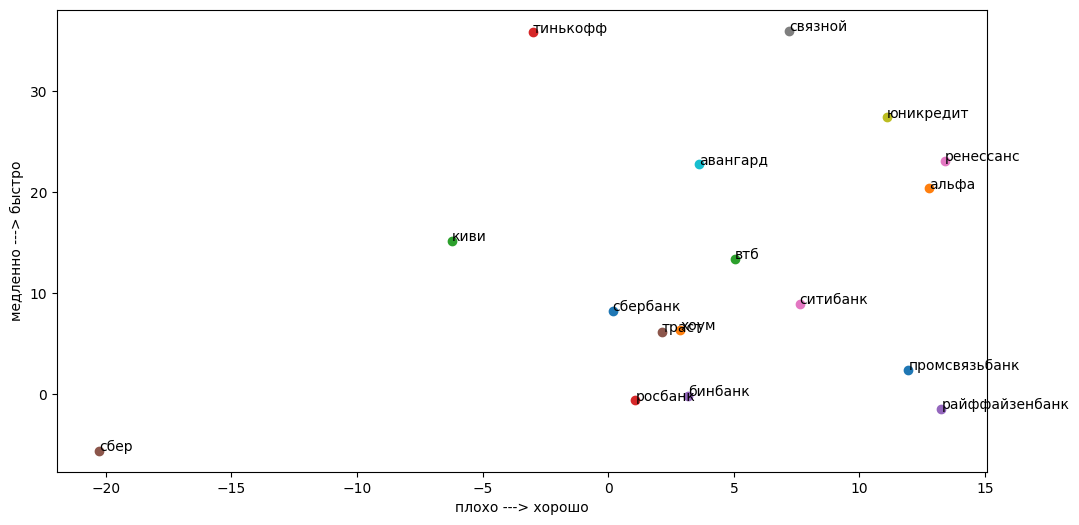

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)

for i in range(len(df_banks)):
    x, y, text = df_banks.iloc[i]['x'], df_banks.iloc[i]['y'], df_banks.iloc[i]['bank']
    ax.scatter(x, y)
    ax.text(x, y, text)

ax.set_xlabel('плохо ---> хорошо')
ax.set_ylabel('медленно ---> быстро')

plt.show()

Самый быстрый - связной, самый тормозной - росбанк, бинбанк, самый хороший - альфа и ренесанс, сбер хуже всех

## Задание 2: распространить метку

In [ ]:
positive_words_start = ['быстрый', 'удобный', 'вежливый', 'качественный', 'комфортный', 'грамотный']
negative_words_start = ['очередь', 'медленно', 'отвратительный', 'совковый', 'обман', 'развод']

nodes = [(w, 1) for w in positive_words_start] + [(w, -1) for w in negative_words_start]
new_nodes = []
random.seed(42)
for word, lbl in nodes:
    for sim_word, weight in w2vec.wv.most_similar(word):
        r = random.random()
        if (weight + r) - weight * r > 0.97:
            new_nodes.append((sim_word, lbl))

new_nodes

[('быстрота', 1),
 ('неудобный', 1),
 ('высокопрофессиональный', 1),
 ('высота', 1),
 ('конкурентоспособный', 1),
 ('квалифицированный', 1),
 ('высококвалифицированный', 1),
 ('профессиональный', 1),
 ('квалифицировать', 1),
 ('духота', -1),
 ('ужасный', -1),
 ('развод', -1),
 ('граб', -1)]

In [ ]:
nodes = new_nodes

In [ ]:
positive_words = ['быстрый', 'удобный', 'вежливый', 'качественный', 'комфортный', 'грамотный']
negative_words = ['очередь', 'медленно', 'отвратительный', 'совковый', 'обман', 'развод']

nodes = [(w, 1) for w in positive_words] + [(w, -1) for w in negative_words]

g = ig.Graph(directed=True)

random.seed(42)

threshold = 0.95

processed_words = positive_words + negative_words

for word, label in nodes:
    g.add_vertex(word, label=label)

positive_words = [positive_words]
negative_words = [negative_words]

while len(nodes) > 0:
    new_nodes = []
    posw = []
    negw = []
    for word, label in nodes:
        src_node = g.vs.select(name = word).indices[0]

        for sim_word, weight in w2vec.wv.most_similar(word):
            if sim_word not in processed_words:
                r = random.random()
                if (weight + r) - weight * r > threshold:
                    new_nodes.append((sim_word, label))
                    processed_words.append(word)
                    if label == 1:
                        posw.append(sim_word)
                    else:
                        negw.append(sim_word)

                    g.add_vertex(sim_word, label=label)
                    trg_node = g.vs.select(name = sim_word).indices[0]
                    g.add_edge(src_node, trg_node, label = lbl)
    if len(posw) > 0:
        positive_words.append(posw)
    if len(negw) > 0:
        negative_words.append(negw)
    nodes = new_nodes

In [ ]:
print(f"Total words: {len(w2vec.wv.key_to_index)}, "
      f"positive words: {sum(len(s) for s in positive_words)}, "
      f"negative words: {sum(len(s) for s in negative_words)}")

Total words: 17201, positive words: 3455, negative words: 7604


<ipython-input-242-ae97b9924504>:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f"positive words: {sum(len(s) for s in positive_words)}, "
<ipython-input-242-ae97b9924504>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f"negative words: {sum(len(s) for s in negative_words)}")


In [ ]:
print(f"Positive steps: {len(positive_words)}, negative_steps: {len(negative_words)}")

Positive steps: 53, negative_steps: 69


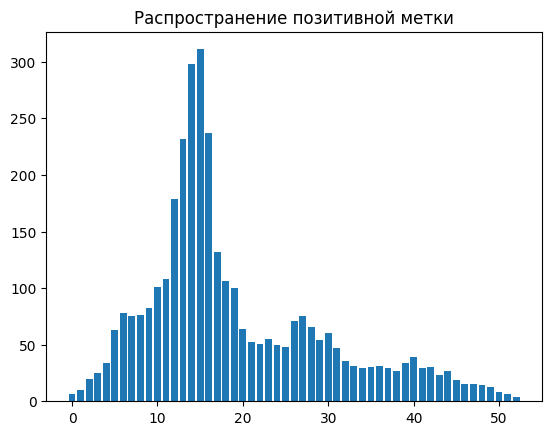

In [ ]:
plt.bar(x=range(len(positive_words)), height=[len(s) for s in positive_words])
plt.title("Распространение позитивной метки")
plt.show()

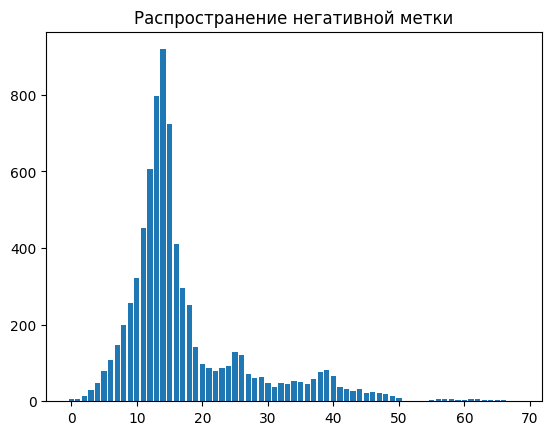

In [ ]:
plt.bar(x=range(len(negative_words)), height=[len(s) for s in negative_words])
plt.title("Распространение негативной метки")
plt.show()

Основные выводы:
- составлены словари для классификации по тональности;
- построены визуализации (TSNE для топ-500, пространство в координатах «плохо — хорошо», «медленно — быстро»);
- распространены позитивные и негативные метки.